In [1]:
from ThymeBoost import ThymeBoost as tb
import seaborn as sns
sns.set_style('darkgrid')

Simple example with yahoo finance grabbing microsoft prices from yahoo finance api documentation. There are gaps in the index so we are just resetting the index to allow fitting. Better to fill gaps or do something else!

In [2]:
import yfinance as yf
msft = yf.Ticker("MSFT")

# get historical market data
hist = msft.history(period="max")

current_df = hist.iloc[-900:-100].reset_index()
future_df = hist.iloc[-100:].reset_index()

y_train = current_df['High']
X_train = current_df[['Volume', 'Stock Splits']]

y_test = future_df['High']
X_test = future_df[['Volume', 'Stock Splits']]

First we will do a simple linear regression:

In [3]:
boosted_model = tb.ThymeBoost(verbose=0)
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           global_cost='mse',
                           fit_type='global',
                           )
predicted_output = boosted_model.predict(output, 100)

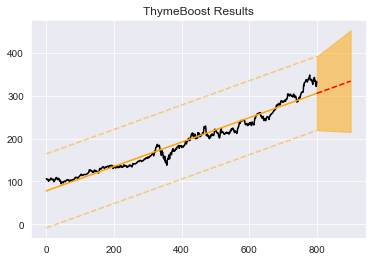

In [4]:
boosted_model.plot_results(output, predicted_output)

Nothing too fancy!

Next let's try out a polynomial regression. Just pass the polynomial order to 'poly':

In [5]:
boosted_model = tb.ThymeBoost(verbose=0)
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           poly=2,
                           global_cost='mse',
                           fit_type='global',
                           )
predicted_output = boosted_model.predict(output, 100)

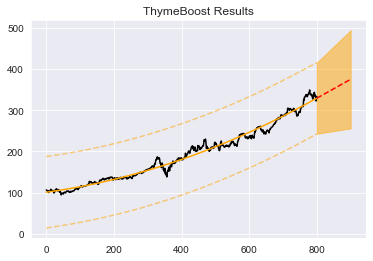

In [6]:
boosted_model.plot_results(output, predicted_output)

And now for a changepoint, simply change the fit_type to local!

In [7]:
boosted_model = tb.ThymeBoost(verbose=0)
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           poly=1,
                           global_cost='mse',
                           fit_type='local',
                           )
predicted_output = boosted_model.predict(output, 100)

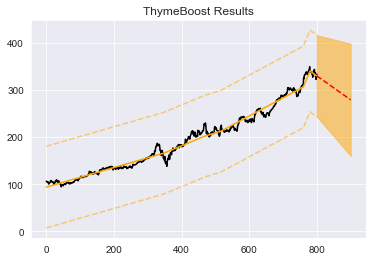

In [8]:
boosted_model.plot_results(output, predicted_output)

There are several considerations when doing changepoint detection, looks like here we are reacting too much at the end point. Let's try changing the cost function from 'mse' to a cost which takes into account the overall complexity of the model. 'maicc' (Modified AICC will get the job done):

In [9]:
boosted_model = tb.ThymeBoost(verbose=0)
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           poly=1,
                           global_cost='maicc',
                           fit_type='local',
                           )
predicted_output = boosted_model.predict(output, 100)

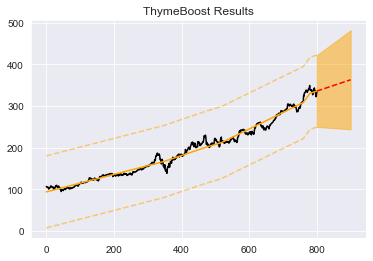

In [10]:
boosted_model.plot_results(output, predicted_output)

Another aspect of changepoint detection involves the number of 'splits' and how we propose splits. By default ThymeBoost will propose 10 splits based on the gradient, we can change this when building the class:

In [20]:
boosted_model = tb.ThymeBoost(verbose=0,
                             approximate_splits=True,
                              n_split_proposals=50,
                             split_strategy='gradient')
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           poly=1,
                           global_cost='maicc',
                           fit_type='local',
                           )
predicted_output = boosted_model.predict(output, 100)

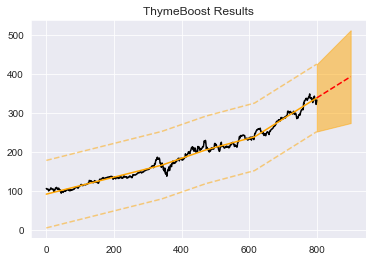

In [21]:
boosted_model.plot_results(output, predicted_output)

By increasing the number of proposals it looks like we can get more reasonable results. This obviously comes at the cost of more computations. An alternative splitting strategy is based on a histogram algorithm.

In [16]:
boosted_model = tb.ThymeBoost(verbose=0,
                             approximate_splits=True,
                             split_strategy='histogram')
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           poly=1,
                           global_cost='maicc',
                           fit_type='local',
                           )
predicted_output = boosted_model.predict(output, 100)

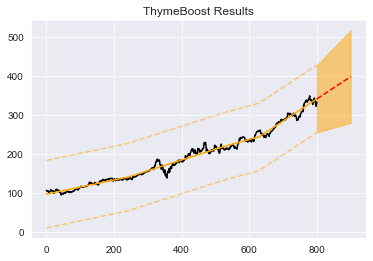

In [17]:
boosted_model.plot_results(output, predicted_output)

Here we propose each split based on a histogram algorithm, this will ignore the split_proposal argument. Looks similar to a high number of proposals and using a gradient strategy but they can be drastically different!

Finally, if we pass approximate_splits=False it will exhaustively try out every data point to split the data on and ignore split_strategy and n_split_proposals.

In [26]:
boosted_model = tb.ThymeBoost(verbose=0,
                             approximate_splits=False)
output = boosted_model.fit(y_train,
                           trend_estimator='linear',
                           poly=1,
                           global_cost='maicc',
                           fit_type='local',
                           )
predicted_output = boosted_model.predict(output, 100)

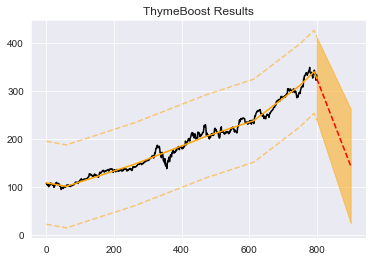

In [27]:
boosted_model.plot_results(output, predicted_output)

Even with maicc cost function, looks like we are overfitting the end point again!